<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2_acquire_OLCI_time_series.ipynb" target="_blank">Acquiring a regional OLCI times series >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store</a>**

</div>
<hr>

# 2.1 OLCI advanced data access via the Data Store using eumdac

### Data used

| Product Description | Data Store collection ID| Product Navigator |
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-3 OLCI level-2 full resolution | EO:EUM:DAT:0407 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* How to refine your <font color="#138D75">**searches**</font> for OLCI products in the EUMETSAT Data Store using the `eumdac client`
* How to <font color="#138D75">**download**</font> components of products
* How to pre-screen downloads based on flags

### Outline

The EUMETSAT Data Store offers many ways to interact with data in order to refine searches. Many of these methods are supported by the EUMETSAT Data Access Client (`eumdac`). In this notebook we will showcase some of the possibilities for using `eumdac` to better interact with OLCI collections. This notebook assumes that you already have an understanding of the available Data Store interfaces, which you can gain by running the **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store</a>** notebook.


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
1. [Example 1: Filter by collections](#section1)
1. [Example 2: Filter by time](#section2)
1. [Example 3: Filter by space and time](#section3)
1. [Example 4: Download by component](#section4)
1. [Example 5: Filter by flag](#section5)

<hr>

In [1]:
import os
import json
import datetime
import shutil
import eumdac
import inspect
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import eumartools
from shapely import geometry, vectorized

# Create a download directory for our SLSTR products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

Before we use the Data Store to download data, we must first authenticate our access and retrieve an access token. More information on setting this up can be found in the **<a href="../1_OLCI_introductory/1_1a_OLCI_data_access_Data_Store.ipynb">1_1a_OLCI_data_access_Data_Store</a>** notebook.

In [2]:
# load credentials
with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
    credentials = json.load(json_file)
    token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
    print(f"This token '{token}' expires {token.expiration}")

# create data store object
datastore = eumdac.DataStore(token)

This token '1650bc52-290f-33d5-b202-d2ae52a7218a' expires 2022-07-04 15:04:18.407414


We will work with the OLCI Level-2 full resolution collection throughout this notebook. The code for this is `EO:EUM:DAT:0407`

In [3]:
# set collection ID for OLCI L2 WFR
collectionID = 'EO:EUM:DAT:0407'

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Example 1: Filtering by collection
[Back to top](#TOC_TOP)

</div>

To filter by collection, we simply provide the collectionID to the `datastore.get_collection method`

In [4]:
# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(selected_collection.title)

OLCI Level 2 Ocean Colour Full Resolution - Sentinel-3


<div class="alert alert-info" role="alert">

## <a id='section2'></a>Example 2: Filtering by time
[Back to top](#TOC_TOP)

</div>

To get the latest product in a collection, we can just ask for the `.first()` method, when searching in our selected collection using `.search()`.

In [5]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()
print(latest)

S3A_OL_2_WFR____20220704T093503_20220704T093803_20220704T115546_0180_087_136_1440_MAR_O_NR_003.SEN3


To filter by time, we can pass python datetime arguments to the **dtstart** and **dtend** arguments of our collection when using the `.search()` method.

In [6]:
# time filter the collection for products
start = datetime.datetime(2022, 1, 23, 16, 0)
end = datetime.datetime(2022, 1, 23, 16, 15)
products = selected_collection.search(dtstart=start, dtend=end)

for product in products:
    print(product)

S3B_OL_2_WFR____20220123T161232_20220123T161532_20220125T055503_0180_061_382_3420_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T160932_20220123T161232_20220125T055441_0179_061_382_3240_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T160632_20220123T160932_20220125T055422_0179_061_382_3060_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T160332_20220123T160632_20220125T055400_0179_061_382_2880_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T160032_20220123T160332_20220125T055340_0179_061_382_2700_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T155732_20220123T160032_20220125T055318_0179_061_382_2520_MAR_O_NT_003.SEN3


<div class="alert alert-info" role="alert">

## <a id='section3'></a>Example 3: Filtering by space and time
[Back to top](#TOC_TOP)

</div>

We can also add geographical filtering by passing in a <a href="https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry" target="_blank">Well Known Text</a> (WKT) format region of interest into the **geo** argument of the `.search()` method.

In [7]:
# space/time filter the collection for products
selected_collection = datastore.get_collection(collectionID)
start = datetime.datetime(2022, 1, 23)
end = datetime.datetime(2022, 1, 24)
roi = [[-1.0, -1.0], [4.0, -4.0], [8.0, -2.0], [9.0, 2.0], [6.0, 4.0], [1.0, 5.0], [-1.0, -1.0]]

products = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),
    dtstart=start, 
    dtend=end)

for product in products:
    print(product)

S3A_OL_2_WFR____20220123T100205_20220123T100505_20220124T223346_0179_081_136_3060_MAR_O_NT_003.SEN3
S3A_OL_2_WFR____20220123T095905_20220123T100205_20220124T223325_0179_081_136_2880_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T092235_20220123T092535_20220124T223420_0179_061_378_3060_MAR_O_NT_003.SEN3
S3B_OL_2_WFR____20220123T091935_20220123T092235_20220124T223353_0179_061_378_2880_MAR_O_NT_003.SEN3


<div class="alert alert-info" role="alert">

## <a id='section4'></a>Example 4: Downloading by component
[Back to top](#TOC_TOP)

</div>

It is possible to download any component of a SAFE format file. This can be achieved by using iterating through the `entries` attribute of a product and string matching to your component of interest - in this case the manifest file.

*Note: It is not currently possible to download a single variable from **inside** a netCDF file*.

In [8]:
# Get the latest product in a collection
selected_collection = datastore.get_collection(collectionID)
latest = selected_collection.search().first()

for entry in latest.entries:
    if 'xfdumanifest.xml' in entry:
        with latest.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name),
                                                    mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

Download of file xfdumanifest.xml finished.


<div class="alert alert-info" role="alert">

## <a id='section5'></a>Example 5: Filtering by flag
[Back to top](#TOC_TOP)

</div>

As OLCI Level-2 product store flags in a separate netCDF file, we can choose to download the flags as a single component, check the information it contains, and then decide if we want the whole product based on the coverage.

In [9]:
# Set the geometry for our ROI
roi = [[6.0, -10.0], [8.0, -10.0], [8.0, -8.0], [6.0, -8.0], [6.0, -10.0]]

In [10]:
selected_collection = datastore.get_collection(collectionID)
# Get the latest product in a collection that matches this ROI
latest = selected_collection.search(
    geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in roi])),).first()

# Get the flag product (for OLCI L2 this is wqsf.nc, for OLCI L1 this is qualityFlags.nc) and coordinates
for entry in latest.entries:
    if "Oa01_reflectance" in entry:
        required_entry = entry
    if 'wqsf.nc' in entry or 'geo_coordinates.nc' in entry:
        with latest.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products', fsrc.name),
                                                    mode='wb') as fdst:
            print(f'Downloading {fsrc.name}.')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of file {fsrc.name} finished.')

Download of file geo_coordinates.nc finished.
Download of file tie_geo_coordinates.nc finished.
Download of file wqsf.nc finished.


In [11]:
# Read in the coordinate data and build a spatial mask
geo_fid = xr.open_dataset(os.path.join(os.getcwd(), 'products', 'geo_coordinates.nc'))
lat = geo_fid.get('latitude').data
lon = geo_fid.get('longitude').data
geo_fid.close()

point_mask = vectorized.contains(geometry.Polygon(roi), lon,lat)

In [12]:
# Now check the flag content for our polygon
flag_file = os.path.join(os.getcwd(), 'products', 'wqsf.nc')
flag_variable = 'WQSF'
flags_to_use = ['CLOUD','LAND']
flag_mask = eumartools.flag_mask(flag_file, flag_variable, flags_to_use)

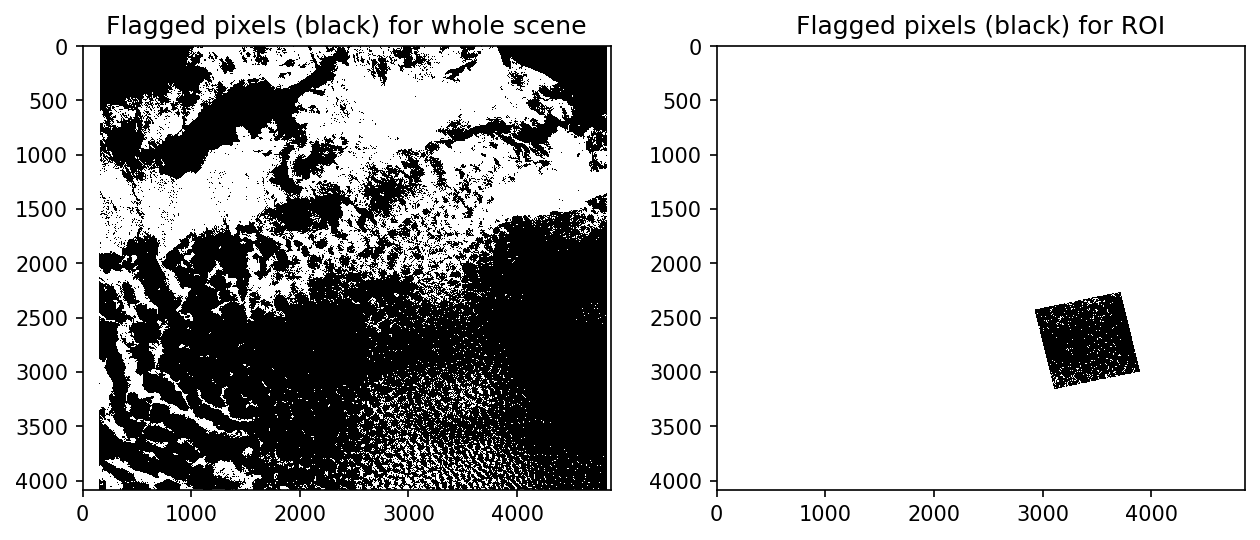

In [13]:
# Now find the union of the spatil and flag mask
fig1, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 10), dpi=150)
ax1.set_title('Flagged pixels (black) for whole scene')
ax1.imshow(flag_mask, interpolation="none", cmap=plt.cm.Greys)
ax2.set_title('Flagged pixels (black) for ROI')
ax2.imshow(point_mask*flag_mask, interpolation="none", cmap=plt.cm.Greys)
plt.show()

In [14]:
# Now check the % flag cover in our ROI. Then you can decide if you want the full product
pc_cover = int(np.sum(point_mask*flag_mask)/np.sum(point_mask)*100)
print(f'Percent flag cover {pc_cover}%')

Percent flag cover 93%


In [15]:
pc_cover_threshold = 40
if pc_cover > pc_cover_threshold:
    with latest.open(entry=required_entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name),
                                                mode='wb') as fdst:
        print(f'Downloading {fsrc.name}.')
        shutil.copyfileobj(fsrc, fdst)
        print(f'Download of file {fsrc.name} finished.')
else:
    print(f'Percent flag cover < threshold ({pc_cover_threshold}%), skipping download')

Download of file Oa01_reflectance.nc finished.


<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2_acquire_OLCI_time_series.ipynb" target="_blank">Acquiring a regional OLCI times series >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>